<a href="https://colab.research.google.com/github/Snigdha-prime/Machine-learning-assignment/blob/main/Turboshaft_engine_fault_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Helicopter Turboshaft Fault Detection

This notebook demonstrates how to train and evaluate several supervised machine‑learning algorithms on a dataset of helicopter turboshaft engine sensor readings.  

The dataset contains hourly measurements from March 1, 2024 to December 31, 2024. Each sample records sensor readings (temperature, pressure, vibration, speed, fuel flow, altitude, airspeed, ambient temperature) and a fault label indicating the engine’s condition (e.g., *Normal*, *Compressor Degradation*, *Turbine Blade Damage*, *Sensor Malfunction*, *Fuel System Anomaly*, *Excessive Vibration Fault*).  

We will:

1. Load and inspect the dataset.
2. Preprocess the data (drop the timestamp, encode labels, split into training and testing sets).
3. Train three classifiers (logistic regression, decision tree, random forest).
4. Evaluate each model using accuracy, classification reports and confusion matrices.
5. Discuss how class imbalance affects performance and how to mitigate it.



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset (make sure the CSV file is in your Colab session or Google Drive)
file_path = '/content/drive/My Drive/ML/Helicopter_Turboshaft_Fault_Detection.csv'
  # update if you upload to a different path
df = pd.read_csv(file_path)

# Preview the first few rows
pd.set_option('display.max_columns', None)
df.head()


,Timestamp,Temp_Compressor,Temp_Turbine,Pressure_Compressor,Vibration_Compressor,Speed_Turbine,Fuel_Flow,Altitude,Airspeed,Ambient_Temp,Fault_Label
0,3/1/2024 0:00,0.516699,-0.482741,1.218923,0.439431,1.109674,0.259894,-0.457097,0.935177,0.520473,Normal
1,3/1/2024 1:00,-0.137372,-1.071038,-0.581229,0.165394,-0.344521,0.381376,1.416960,-0.804455,-0.461119,Normal
2,3/1/2024 2:00,0.672213,-0.867799,0.268908,1.551952,1.156725,0.647181,0.053060,-1.435661,-1.606553,Normal
3,3/1/2024 3:00,1.573874,-1.351055,0.142967,0.176228,0.047683,-1.703167,-1.739264,-0.980834,0.247414,Normal
4,3/1/2024 4:00,-0.236144,-0.949079,-1.116520,0.251032,0.122548,-0.376294,0.681555,0.341163,-1.328883,Turbine Blade Damage


In [5]:
# Dimensions of the dataset
print(f"Dataset shape: {df.shape}")

# Display column names
df.columns

Dataset shape: (7012, 11)


Index(['Timestamp', 'Temp_Compressor', 'Temp_Turbine', 'Pressure_Compressor',
       'Vibration_Compressor', 'Speed_Turbine', 'Fuel_Flow', 'Altitude',
       'Airspeed', 'Ambient_Temp', 'Fault_Label'],
      dtype='object')

In [6]:
# Check for missing values
missing = df.isnull().sum()
missing

,0
Timestamp,0
Temp_Compressor,0
Temp_Turbine,0
Pressure_Compressor,0
Vibration_Compressor,0
Speed_Turbine,0
Fuel_Flow,0
Altitude,0
Airspeed,0
Ambient_Temp,0


Fault_Label
Normal                       5157
Compressor Degradation        584
Turbine Blade Damage          444
Sensor Malfunction            394
Fuel System Anomaly           218
Excessive Vibration Fault     215
Name: count, dtype: int64


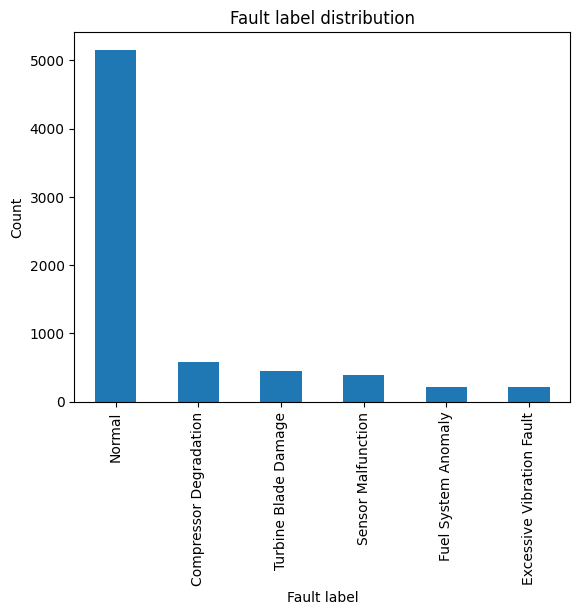

In [7]:
# Distribution of fault labels
label_counts = df['Fault_Label'].value_counts()
print(label_counts)

# Plot class distribution
plt.figure()
label_counts.plot(kind='bar', title='Fault label distribution')
plt.xlabel('Fault label')
plt.ylabel('Count')
plt.show()

In [8]:
# Drop the timestamp column (it is a string; not useful as a numerical feature)
X = df.drop(columns=['Timestamp', 'Fault_Label'])
y = df['Fault_Label']

# Encode the fault labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 5609
Testing samples: 1403


**1. Scale features then Logistic Regression Classifier**

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression accuracy: 0.7356
Classification report (Logistic Regression):
                           precision    recall  f1-score   support

   Compressor Degradation       0.00      0.00      0.00       117
Excessive Vibration Fault       0.00      0.00      0.00        43
      Fuel System Anomaly       0.00      0.00      0.00        43
                   Normal       0.74      1.00      0.85      1032
       Sensor Malfunction       0.00      0.00      0.00        79
     Turbine Blade Damage       0.00      0.00      0.00        89

                 accuracy                           0.74      1403
                macro avg       0.12      0.17      0.14      1403
             weighted avg       0.54      0.74      0.62      1403

Confusion matrix: [[   0    0    0  117    0    0]
 [   0    0    0   43    0    0]
 [   0    0    0   43    0    0]
 [   0    0    0 1032    0    0]
 [   0    0    0   79    0    0]
 [   0    0    0   89    0    0]]


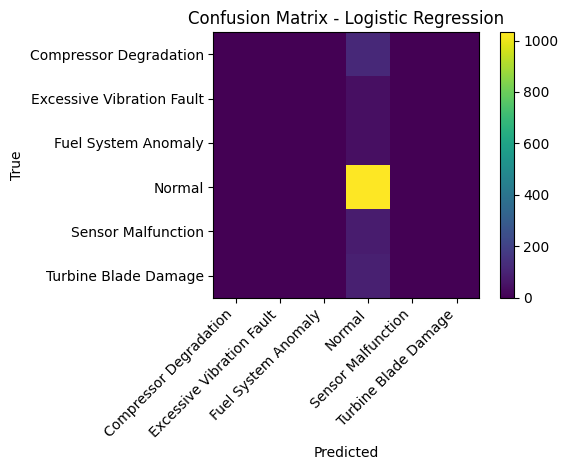

In [9]:
# Pipeline: scale features then logistic regression classifier
log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000, multi_class='auto'))
])

# Train
aaa = log_reg_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = log_reg_pipeline.predict(X_test)

# Evaluate accuracy
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression accuracy: {acc_lr:.4f}")

# Classification report
print("Classification report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_, zero_division=0))

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Confusion matrix:", cm_lr)

# Plot confusion matrix
plt.figure()
plt.imshow(cm_lr)
plt.title('Confusion Matrix - Logistic Regression')
plt.xticks(ticks=np.arange(len(le.classes_)), labels=le.classes_, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(le.classes_)), labels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.tight_layout()
plt.show()

**2. Train decision tree classifier**

Decision Tree accuracy: 0.5296
Classification report (Decision Tree):
                           precision    recall  f1-score   support

   Compressor Degradation       0.06      0.07      0.07       117
Excessive Vibration Fault       0.00      0.00      0.00        43
      Fuel System Anomaly       0.05      0.05      0.05        43
                   Normal       0.73      0.70      0.71      1032
       Sensor Malfunction       0.03      0.04      0.04        79
     Turbine Blade Damage       0.10      0.12      0.11        89

                 accuracy                           0.53      1403
                macro avg       0.16      0.16      0.16      1403
             weighted avg       0.55      0.53      0.54      1403

Confusion matrix: [[  8   3   2  89   5  10]
 [  3   0   0  31   6   3]
 [  4   2   2  31   3   1]
 [104  35  33 719  62  79]
 [  1   3   4  59   3   9]
 [  8   3   2  52  13  11]]


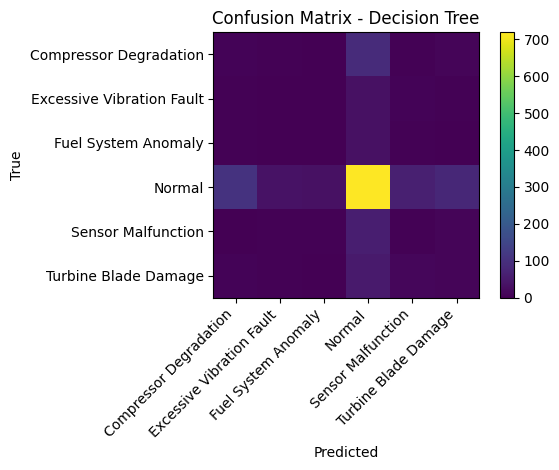

In [10]:
# Train decision tree classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_dt = dt_model.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree accuracy: {acc_dt:.4f}")

print("Classification report (Decision Tree):")
print(classification_report(y_test, y_pred_dt, target_names=le.classes_, zero_division=0))

cm_dt = confusion_matrix(y_test, y_pred_dt)
print("Confusion matrix:", cm_dt)

plt.figure()
plt.imshow(cm_dt)
plt.title('Confusion Matrix - Decision Tree')
plt.xticks(ticks=np.arange(len(le.classes_)), labels=le.classes_, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(le.classes_)), labels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.tight_layout()
plt.show()

**3.Train Random Forest Classifier (with 200 trees)**

Random Forest accuracy: 0.7356
Classification report (Random Forest):
                           precision    recall  f1-score   support

   Compressor Degradation       0.00      0.00      0.00       117
Excessive Vibration Fault       0.00      0.00      0.00        43
      Fuel System Anomaly       0.00      0.00      0.00        43
                   Normal       0.74      1.00      0.85      1032
       Sensor Malfunction       0.00      0.00      0.00        79
     Turbine Blade Damage       0.00      0.00      0.00        89

                 accuracy                           0.74      1403
                macro avg       0.12      0.17      0.14      1403
             weighted avg       0.54      0.74      0.62      1403

Confusion matrix: [[   0    0    0  117    0    0]
 [   0    0    0   43    0    0]
 [   0    0    0   43    0    0]
 [   0    0    0 1032    0    0]
 [   0    0    0   79    0    0]
 [   0    0    0   89    0    0]]


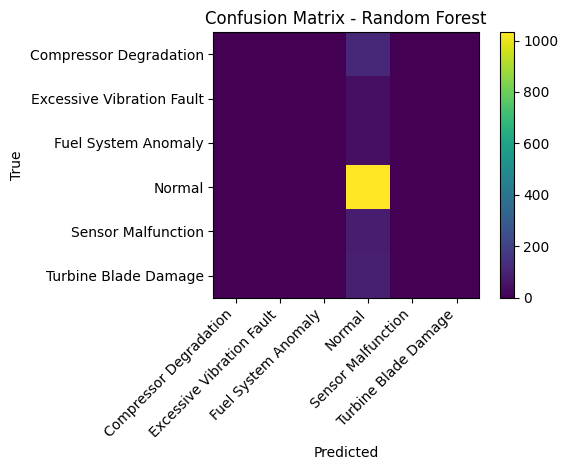

In [11]:
# Train random forest classifier (with 200 trees)
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest accuracy: {acc_rf:.4f}")

print("Classification report (Random Forest):")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_, zero_division=0))

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion matrix:", cm_rf)

plt.figure()
plt.imshow(cm_rf)
plt.title('Confusion Matrix - Random Forest')
plt.xticks(ticks=np.arange(len(le.classes_)), labels=le.classes_, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(le.classes_)), labels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.tight_layout()
plt.show()

### Handling class imbalance

As the class distribution plot shows, the **Normal** class heavily dominates the dataset.  
This imbalance causes models such as logistic regression and random forest to predict the majority class almost exclusively, leading to high overall accuracy but very poor recall for minority classes.  

To address class imbalance you can try:

- **Weighted models** – many scikit‑learn classifiers accept a `class_weight` parameter. For example, `RandomForestClassifier(class_weight='balanced')` assigns weights inversely proportional to class frequencies.
- **Resampling** – techniques like **SMOTE** (Synthetic Minority Over‑sampling Technique) create synthetic samples of minority classes. This requires the `imbalanced‑learn` library.
- **Evaluation metrics** – use metrics like precision, recall and F1‑score for each class instead of accuracy alone.

You can experiment with these techniques to improve performance on minority classes.  
